In [1]:
import pandas as pd
import numpy as np
import json
import pywt
import matplotlib.pyplot as plt

# Wavelet Transform 


### Explanation Slides : https://docs.google.com/presentation/d/1C_ZNlJWIWQeRH9DVWc9ix91cl7YYaRzWbFof70BM02k/edit?usp=sharing

## 1. ETL

In [2]:
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 40000
df = pd.read_csv('all.csv', nrows=nr_rows)

# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

torque_array = []
first_rotation = []
second_rotation = []

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque = torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2 = resultat2.reset_index()

    resultat = resultat.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    resultat2 = resultat2.drop(columns=["Time", "index", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure both dataframes have the same shape by truncating or padding
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)

    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    torque_array.append(torque)

# First Rotation
data = np.array(first_rotation)
squeezed_arr = np.squeeze(data)

# Second Rotation
data2 = np.array(second_rotation)
squeezed_arr2 = np.squeeze(data2)

## Magnitude Scalogram - Shows you magnitude of frequency distribution

## Set Sample Number

In [3]:
# All the plots from here on are just for sample specified 
sample_nr = 4

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


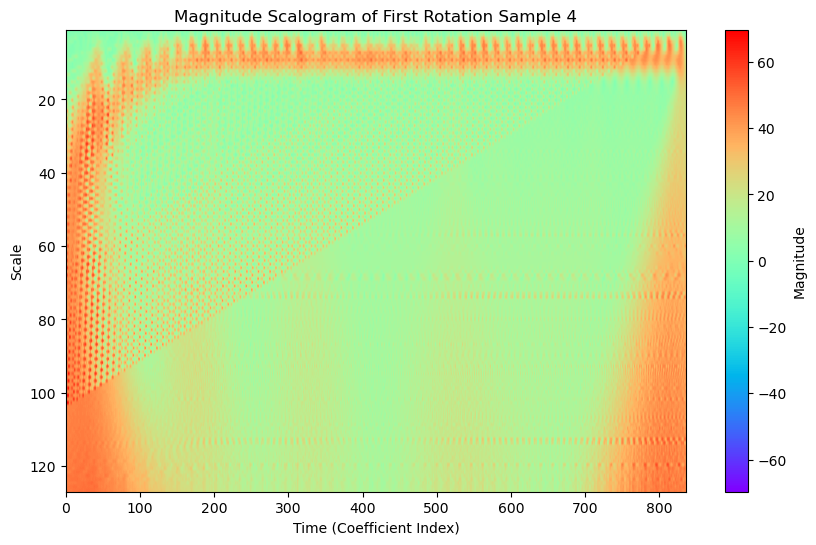

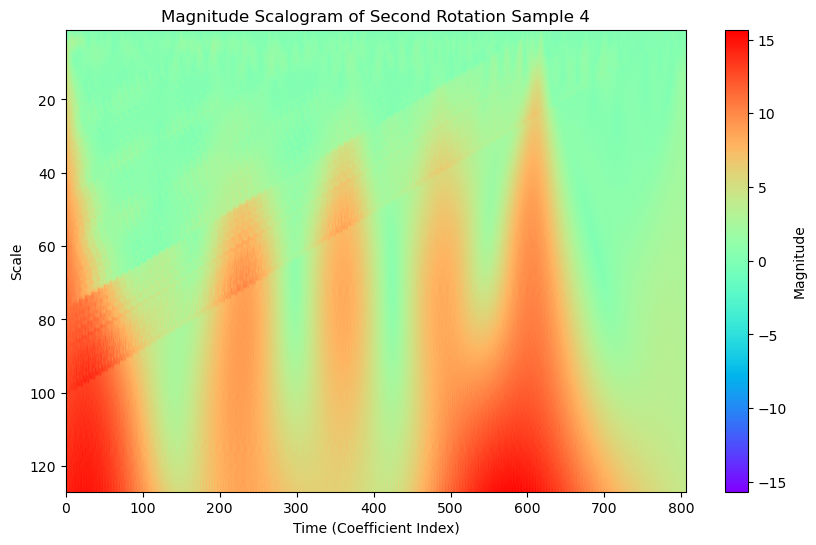

In [4]:
def plot_scalogram(data, title, wavelet='cmor'):
    scales = np.arange(1, 128)  # Define the range of scales
    coeffs, freqs = pywt.cwt(data, scales, wavelet)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coeffs), extent=[0, len(data), scales[-1], scales[0]], cmap='rainbow', aspect='auto',
               vmax=np.abs(coeffs).max(), vmin=-np.abs(coeffs).max())
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (Coefficient Index)')
    plt.ylabel('Scale')
    plt.title(title)
    
    plt.show()

# Plot the magnitude scalogram for the first sample in the first rotation
plot_scalogram(squeezed_arr[sample_nr].flatten(), f'Magnitude Scalogram of First Rotation Sample {sample_nr}')

# Plot the magnitude scalogram for the first sample in the second rotation
plot_scalogram(squeezed_arr2[sample_nr].flatten(), f'Magnitude Scalogram of Second Rotation Sample {sample_nr}')

## Wavelet Transform Analysis 
### Daubechies 20 'db20' (higher the order, more detailed the wavelet)

In [5]:
# Wavelet Transform Analysis
def wavelet_transform(data, wavelet='db20'):
    coeffs = pywt.wavedec(data, wavelet)
    return coeffs

# Perform wavelet transform on the first rotation and second rotation data
wavelet_coeffs_first = []
wavelet_coeffs_second = []

for sample in range(nr_rows):
    coeffs_first = wavelet_transform(squeezed_arr[sample])
    coeffs_second = wavelet_transform(squeezed_arr2[sample])
    wavelet_coeffs_first.append(coeffs_first)
    wavelet_coeffs_second.append(coeffs_second)


## Wavelet Decomposition by Plotting Wavelet Coefficients

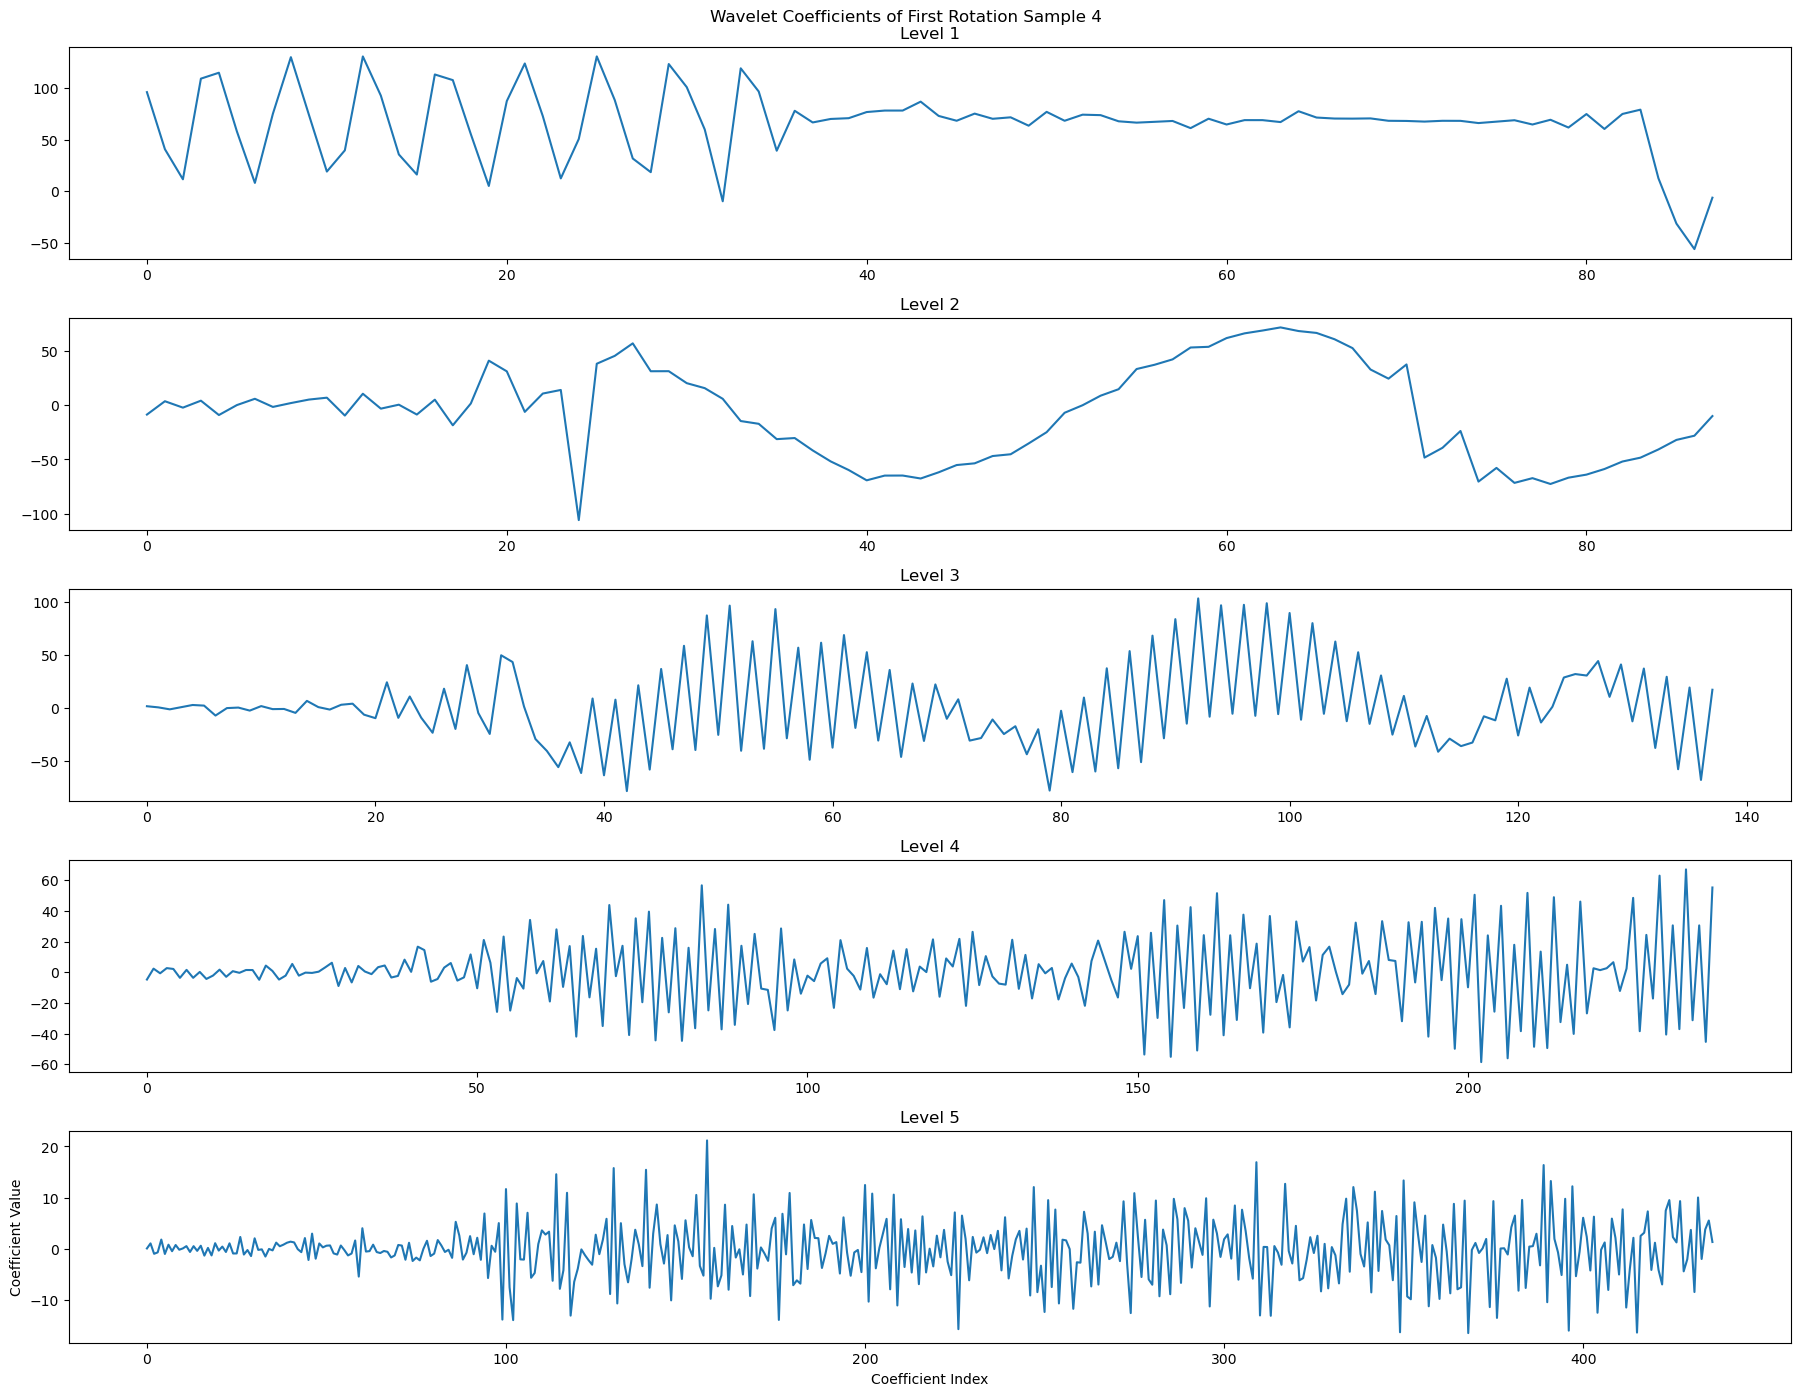

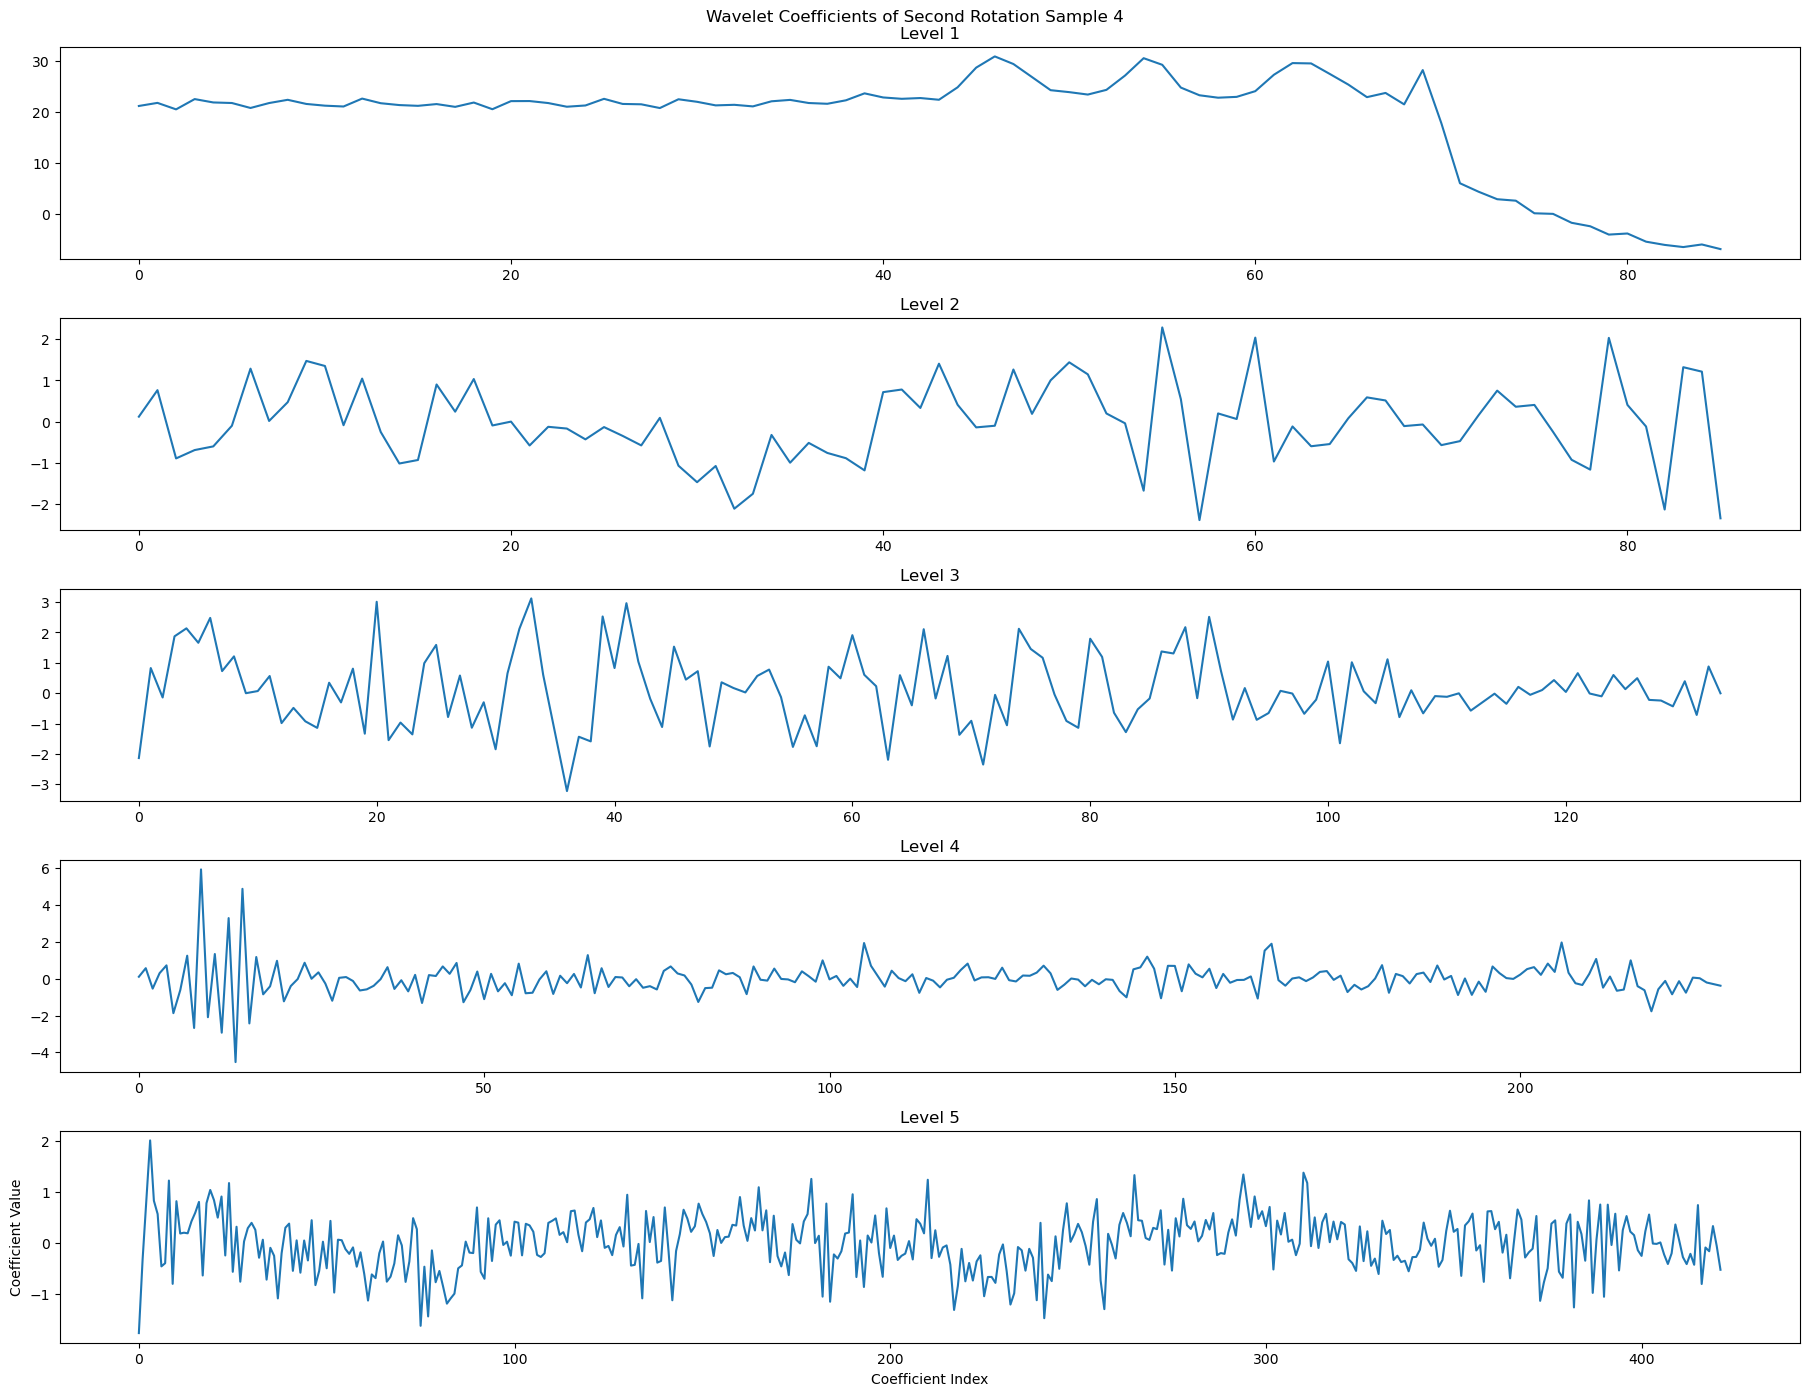

In [6]:
# Example of plotting the wavelet transform of a single sample
def plot_wavelet_coeffs(coeffs, title):
    fig, ax = plt.subplots(len(coeffs), 1, figsize=(18, 14))
    for i, coeff in enumerate(coeffs):
        ax[i].plot(coeff)
        ax[i].set_title(f'Level {i + 1}')
    fig.suptitle(title)
    plt.tight_layout()
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    
    plt.show()

# Plot wavelet coefficients for the first sample in the first rotation and second rotation
#The x-axis represents the coefficient index. It's essentially the position or index of each coefficient in the sequence after the wavelet transform has been applied.
#The y-axis represents the coefficient value, which indicates the magnitude of the wavelet coefficients at each index.

plot_wavelet_coeffs(wavelet_coeffs_first[sample_nr], f'Wavelet Coefficients of First Rotation Sample {sample_nr}')
plot_wavelet_coeffs(wavelet_coeffs_second[sample_nr], f'Wavelet Coefficients of Second Rotation Sample {sample_nr}')

# Second Sample
#plot_wavelet_coeffs(wavelet_coeffs_first[1], 'Wavelet Coefficients of First Rotation (Sample 1)')
#plot_wavelet_coeffs(wavelet_coeffs_second[1], 'Wavelet Coefficients of Second Rotation (Sample 1)')


## Magnitude Scalogram with Cone of Influence 

In [7]:
%%script true
from scipy.interpolate import interp1d
def plot_scalogram_with_coi(data, title, wavelet='cmor'):
    scales = np.arange(1, 128)  # Define the range of scales
    coeffs, freqs = pywt.cwt(data, scales, wavelet)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coeffs), extent=[0, len(data), scales[-1], scales[0]], cmap='jet', aspect='auto',
               vmax=np.abs(coeffs).max(), vmin=-np.abs(coeffs).max())
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (Coefficient Index)')
    plt.ylabel('Scale')
    plt.title(title)
    
    # Calculate the cone of influence
    time = np.arange(len(data))
    coi = np.sqrt(2) * scales  # Cone of influence calculation
    coi = np.minimum(coi, scales[-1])
    coi_interp = interp1d(np.arange(len(scales)), coi, kind='linear', fill_value="extrapolate")(np.linspace(0, len(scales)-1, len(data)))
    
    # Plot the cone of influence
    plt.plot(time, coi_interp, 'k--', label='Cone of Influence')
    plt.plot(time, scales[-1] - coi_interp, 'k--')
    plt.fill_between(time, coi_interp, scales[-1] - coi_interp, color='white', alpha=0.3)

    plt.ylim([scales[-1], scales[0]])  # Correctly setting the scale limits
    plt.legend()
    plt.show()

# Plot the magnitude scalogram with the cone of influence for the first sample in the first rotation
plot_scalogram_with_coi(squeezed_arr[sample_nr].flatten(), f'Magnitude Scalogram of First Rotation Sample {sample_nr}')

## Wavelet Discrete Meyer Transform

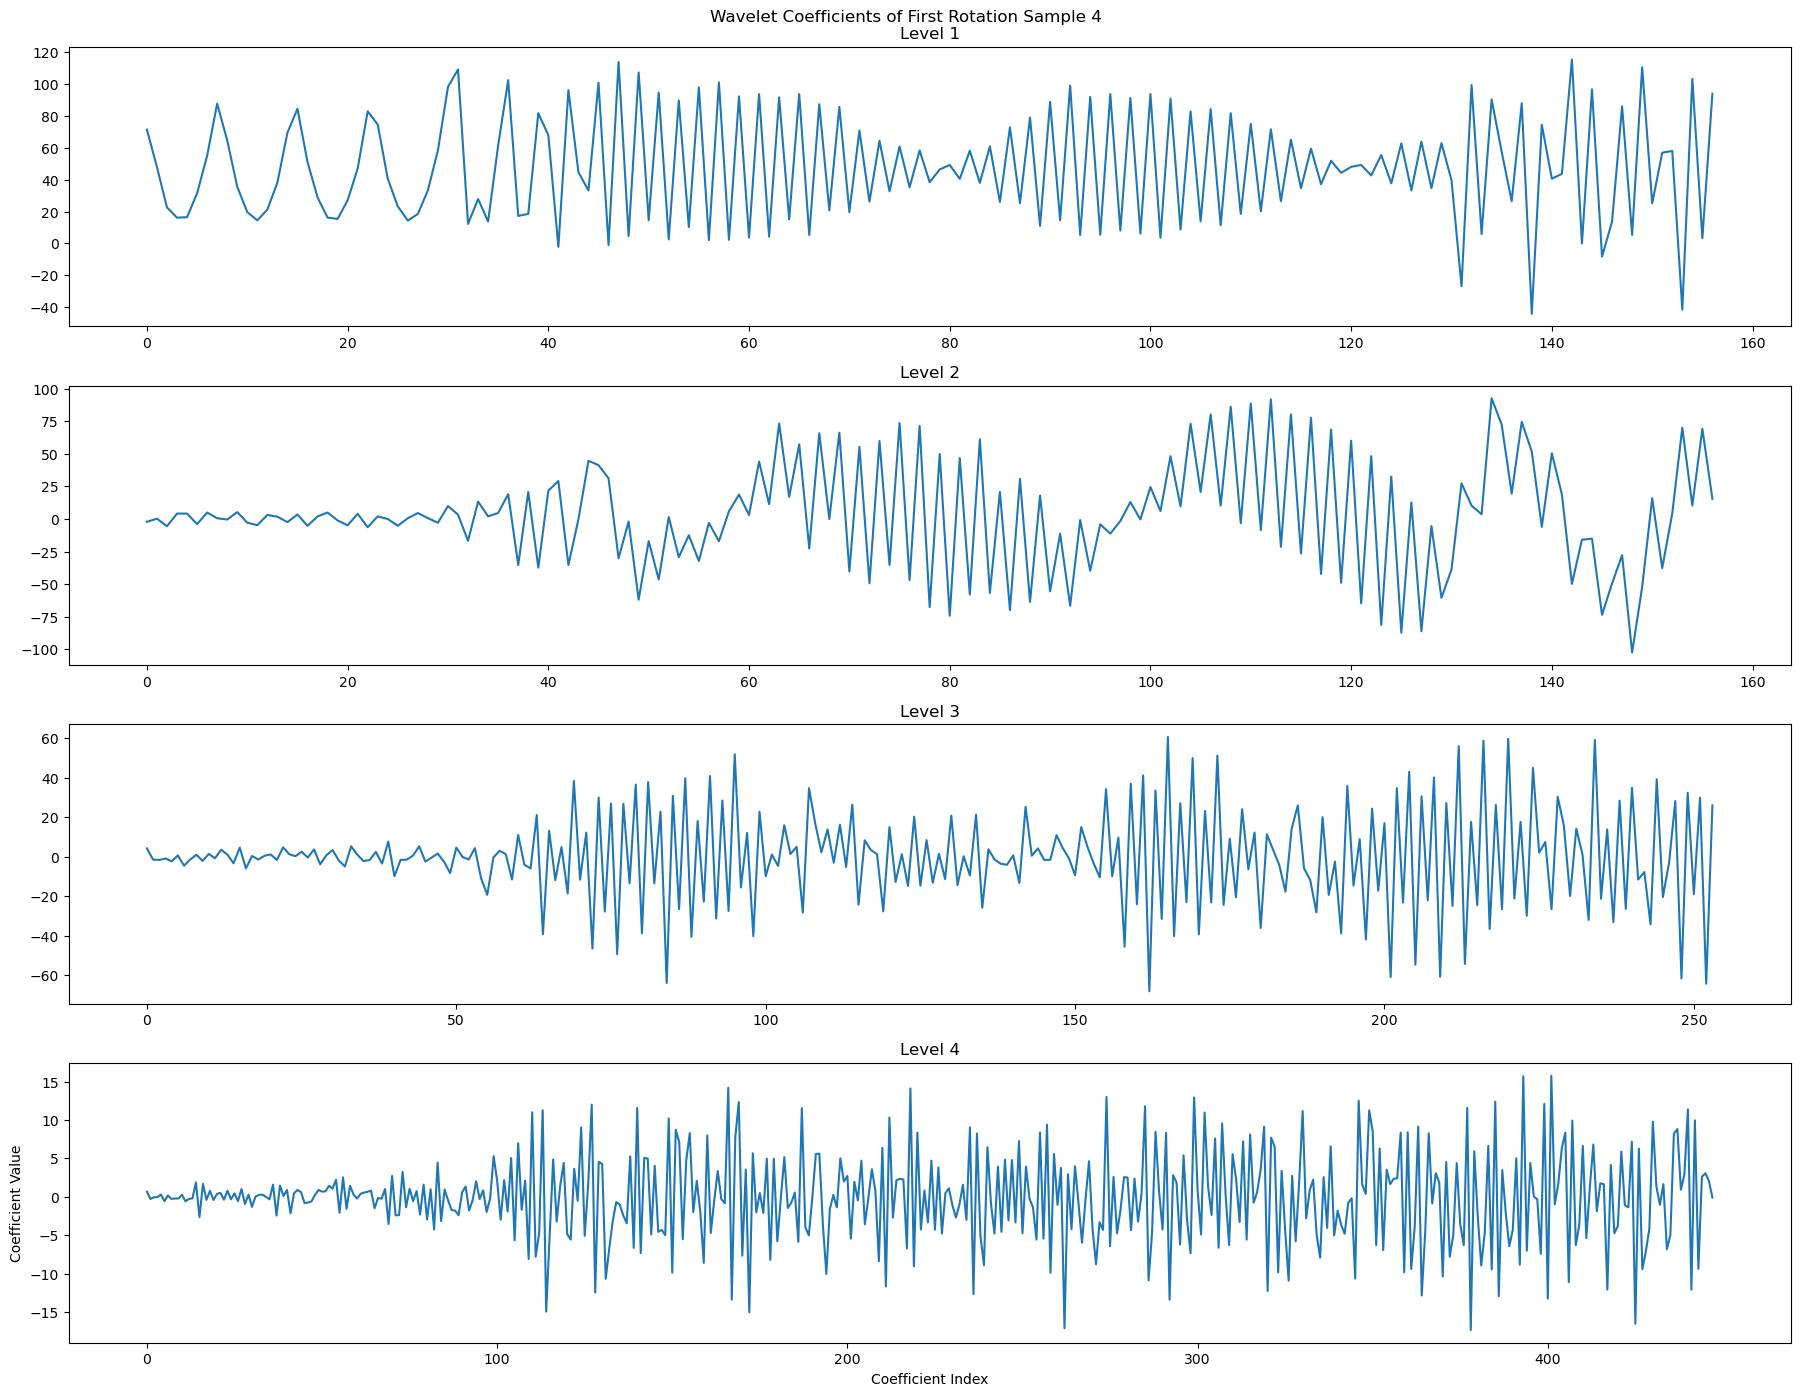

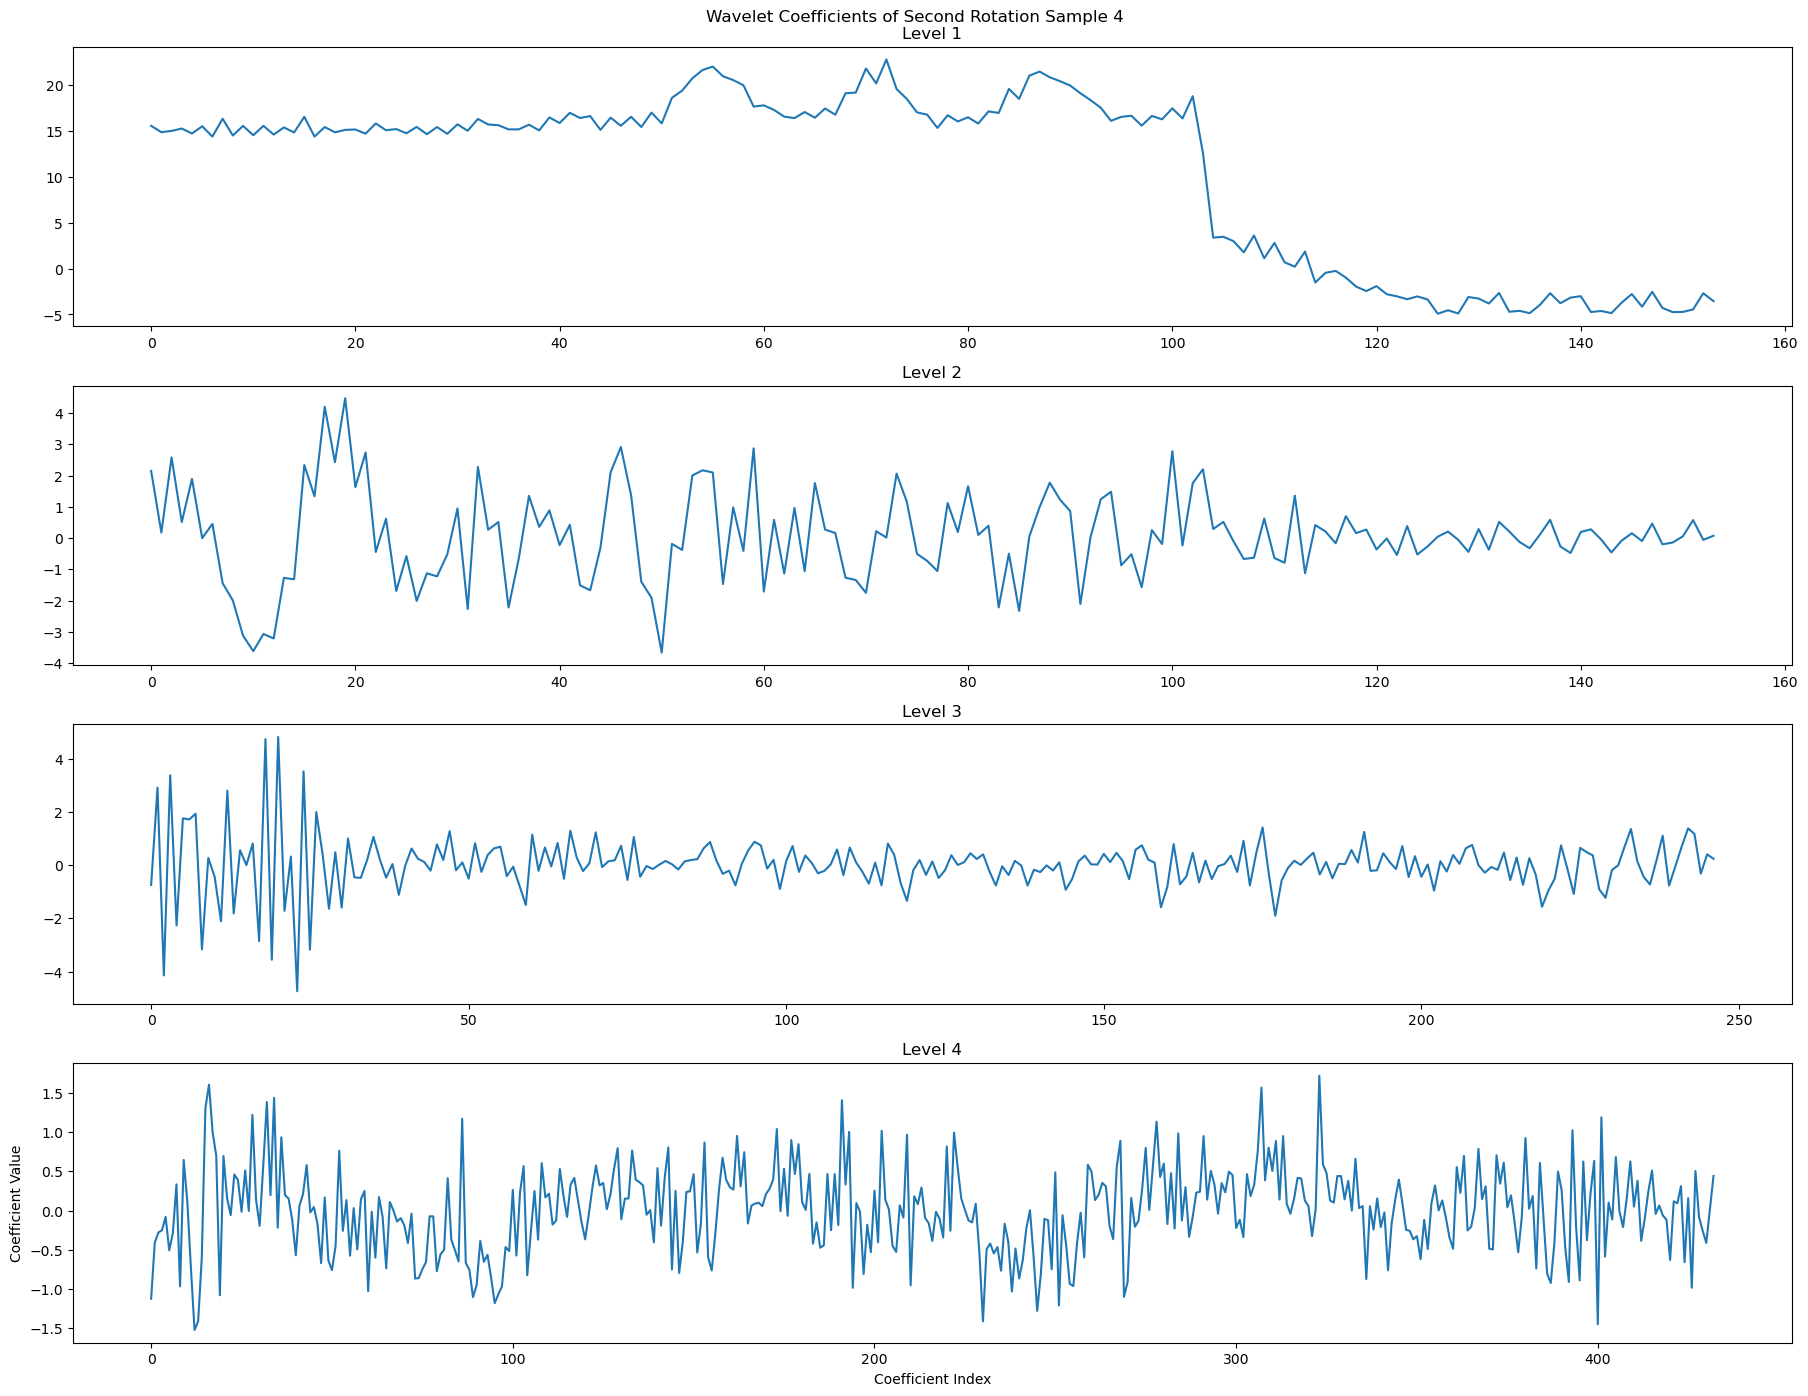

In [8]:
# Wavelet Transform Analysis
def wavelet_transform(data, wavelet='dmey'):
    coeffs = pywt.wavedec(data, wavelet)
    return coeffs

# Perform wavelet transform on the first rotation and second rotation data
wavelet_coeffs_first = []
wavelet_coeffs_second = []

for sample in range(nr_rows):
    coeffs_first = wavelet_transform(squeezed_arr[sample])
    coeffs_second = wavelet_transform(squeezed_arr2[sample])
    wavelet_coeffs_first.append(coeffs_first)
    wavelet_coeffs_second.append(coeffs_second)

# Example of plotting the wavelet transform of a single sample
def plot_wavelet_coeffs(coeffs, title):
    fig, ax = plt.subplots(len(coeffs), 1, figsize=(18, 14))
    for i, coeff in enumerate(coeffs):
        ax[i].plot(coeff)
        ax[i].set_title(f'Level {i + 1}')
    fig.suptitle(title)
    plt.tight_layout()
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    
    plt.show()

plot_wavelet_coeffs(wavelet_coeffs_first[sample_nr], f'Wavelet Coefficients of First Rotation Sample {sample_nr}')
plot_wavelet_coeffs(wavelet_coeffs_second[sample_nr], f'Wavelet Coefficients of Second Rotation Sample {sample_nr}')



## Cluster Time Series Before Using Wavelet Transform

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7328ecb42670>
Traceback (most recent call last):
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


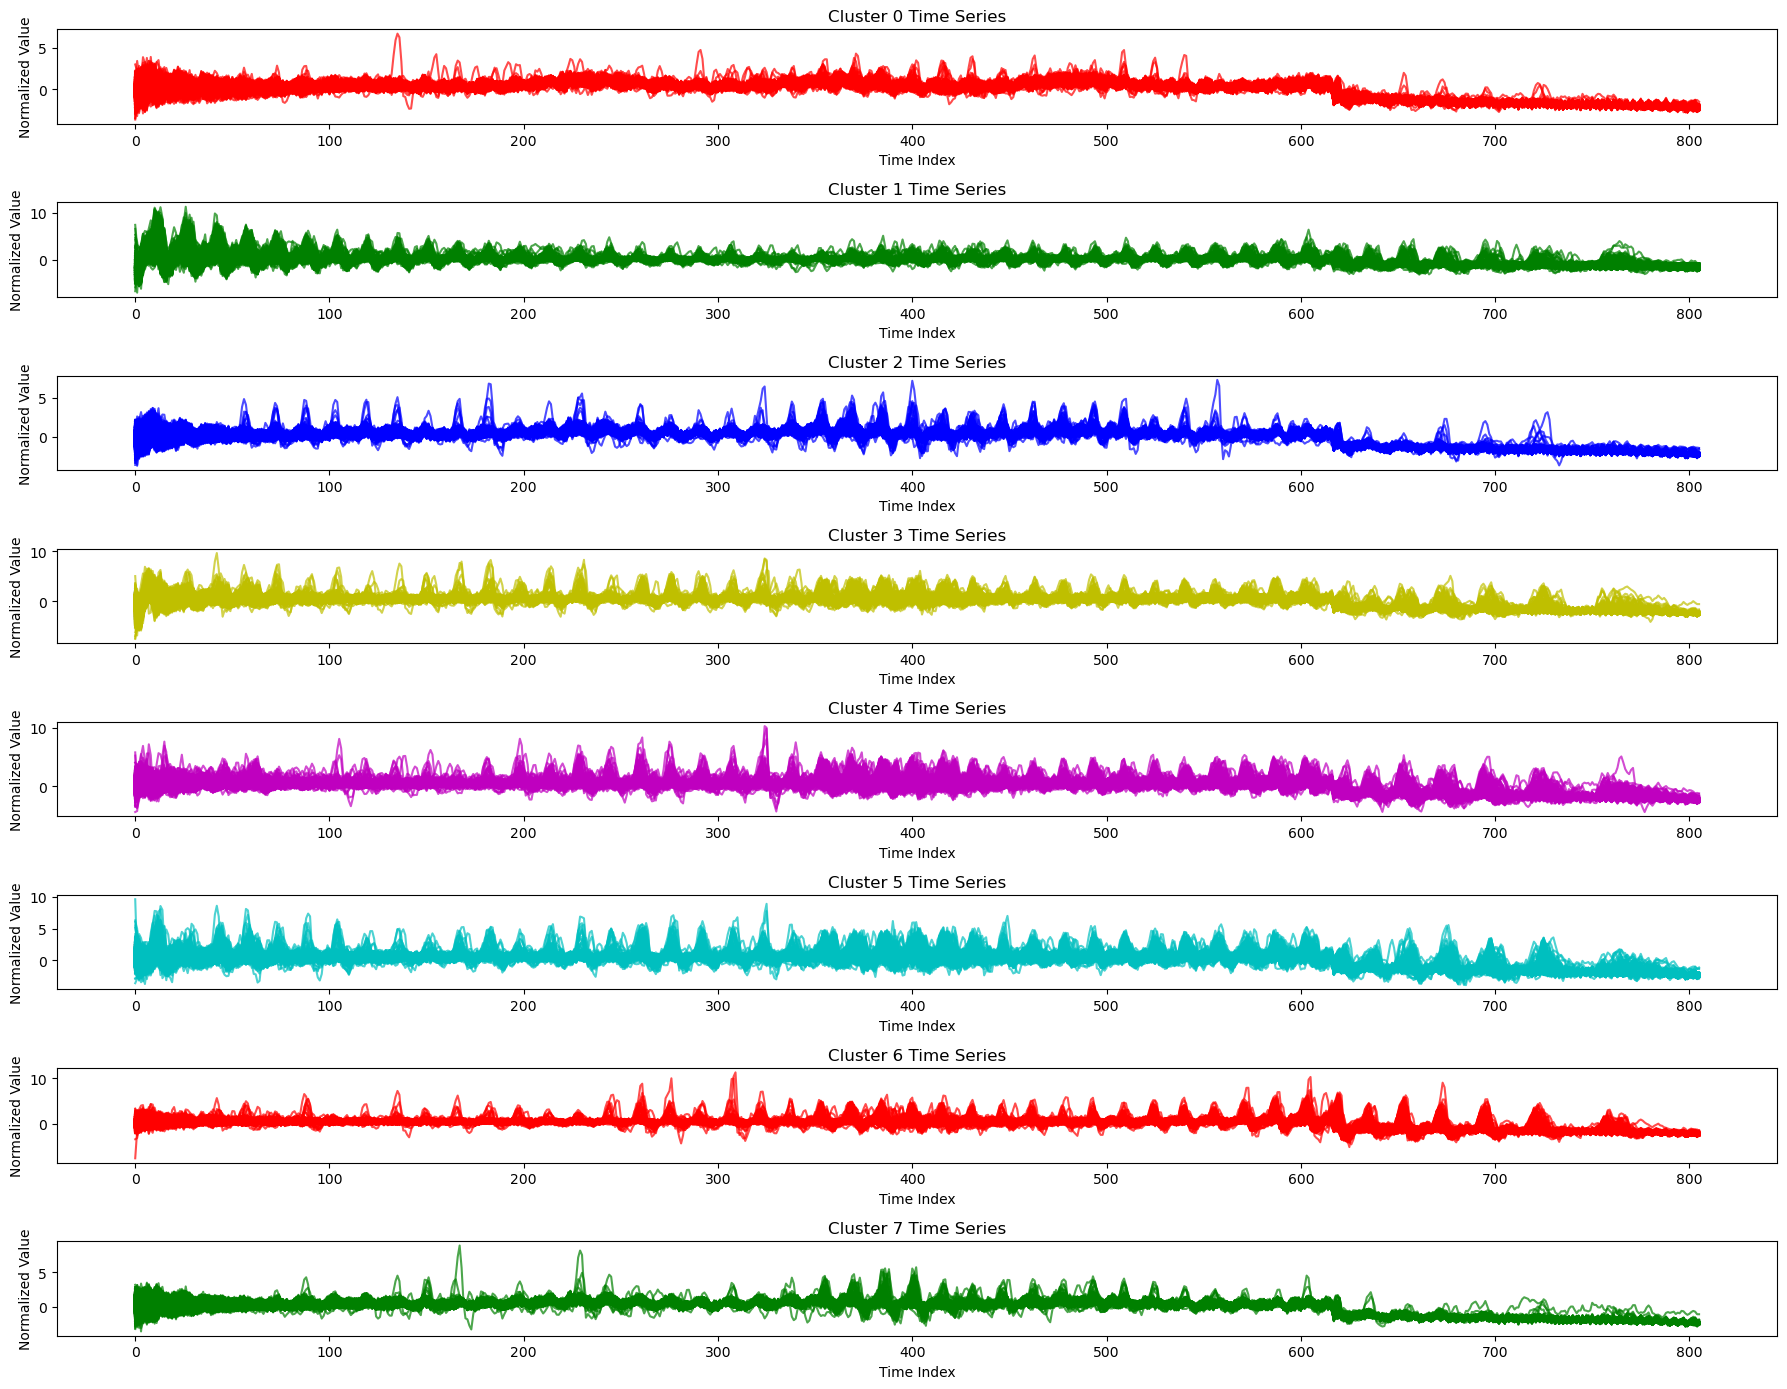

In [9]:
from sklearn.cluster import KMeans
# Second Rotation
cluster_data=squeezed_arr2

# Normalize the data
data_normalized = (cluster_data - np.mean(cluster_data, axis=1).reshape(-1, 1)) / np.std(cluster_data, axis=1).reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(data_normalized)

colors = ['r', 'g', 'b', 'y', 'm', 'c'] 
unique_clusters = np.unique(clusters)

# Create a single figure with a grid of subplots
fig, axes = plt.subplots(nrows=len(unique_clusters), ncols=1, figsize=(18, 14))  # Adjust nrows and ncols as needed

# Loop through clusters and plot in subplots
for ax, cluster_id in zip(axes.flat, unique_clusters):  # zip flattens the axes for one-dimensional iteration
    for i, series in enumerate(data_normalized):
        if clusters[i] == cluster_id:
            ax.plot(series, color=colors[cluster_id % len(colors)], alpha=0.7)  # Use alpha for better visibility

    # Set labels and title for each subplot (optional)
    ax.set_title(f'Cluster {cluster_id} Time Series')
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Normalized Value')

# Adjust layout (optional)
plt.tight_layout()

# Show the entire figure with subplots
plt.show()

### Wavelet Transform on Individual Clusters to See How they are Similar/Different

## Single Level Wavelet Transform - Possibly Wrong Approach

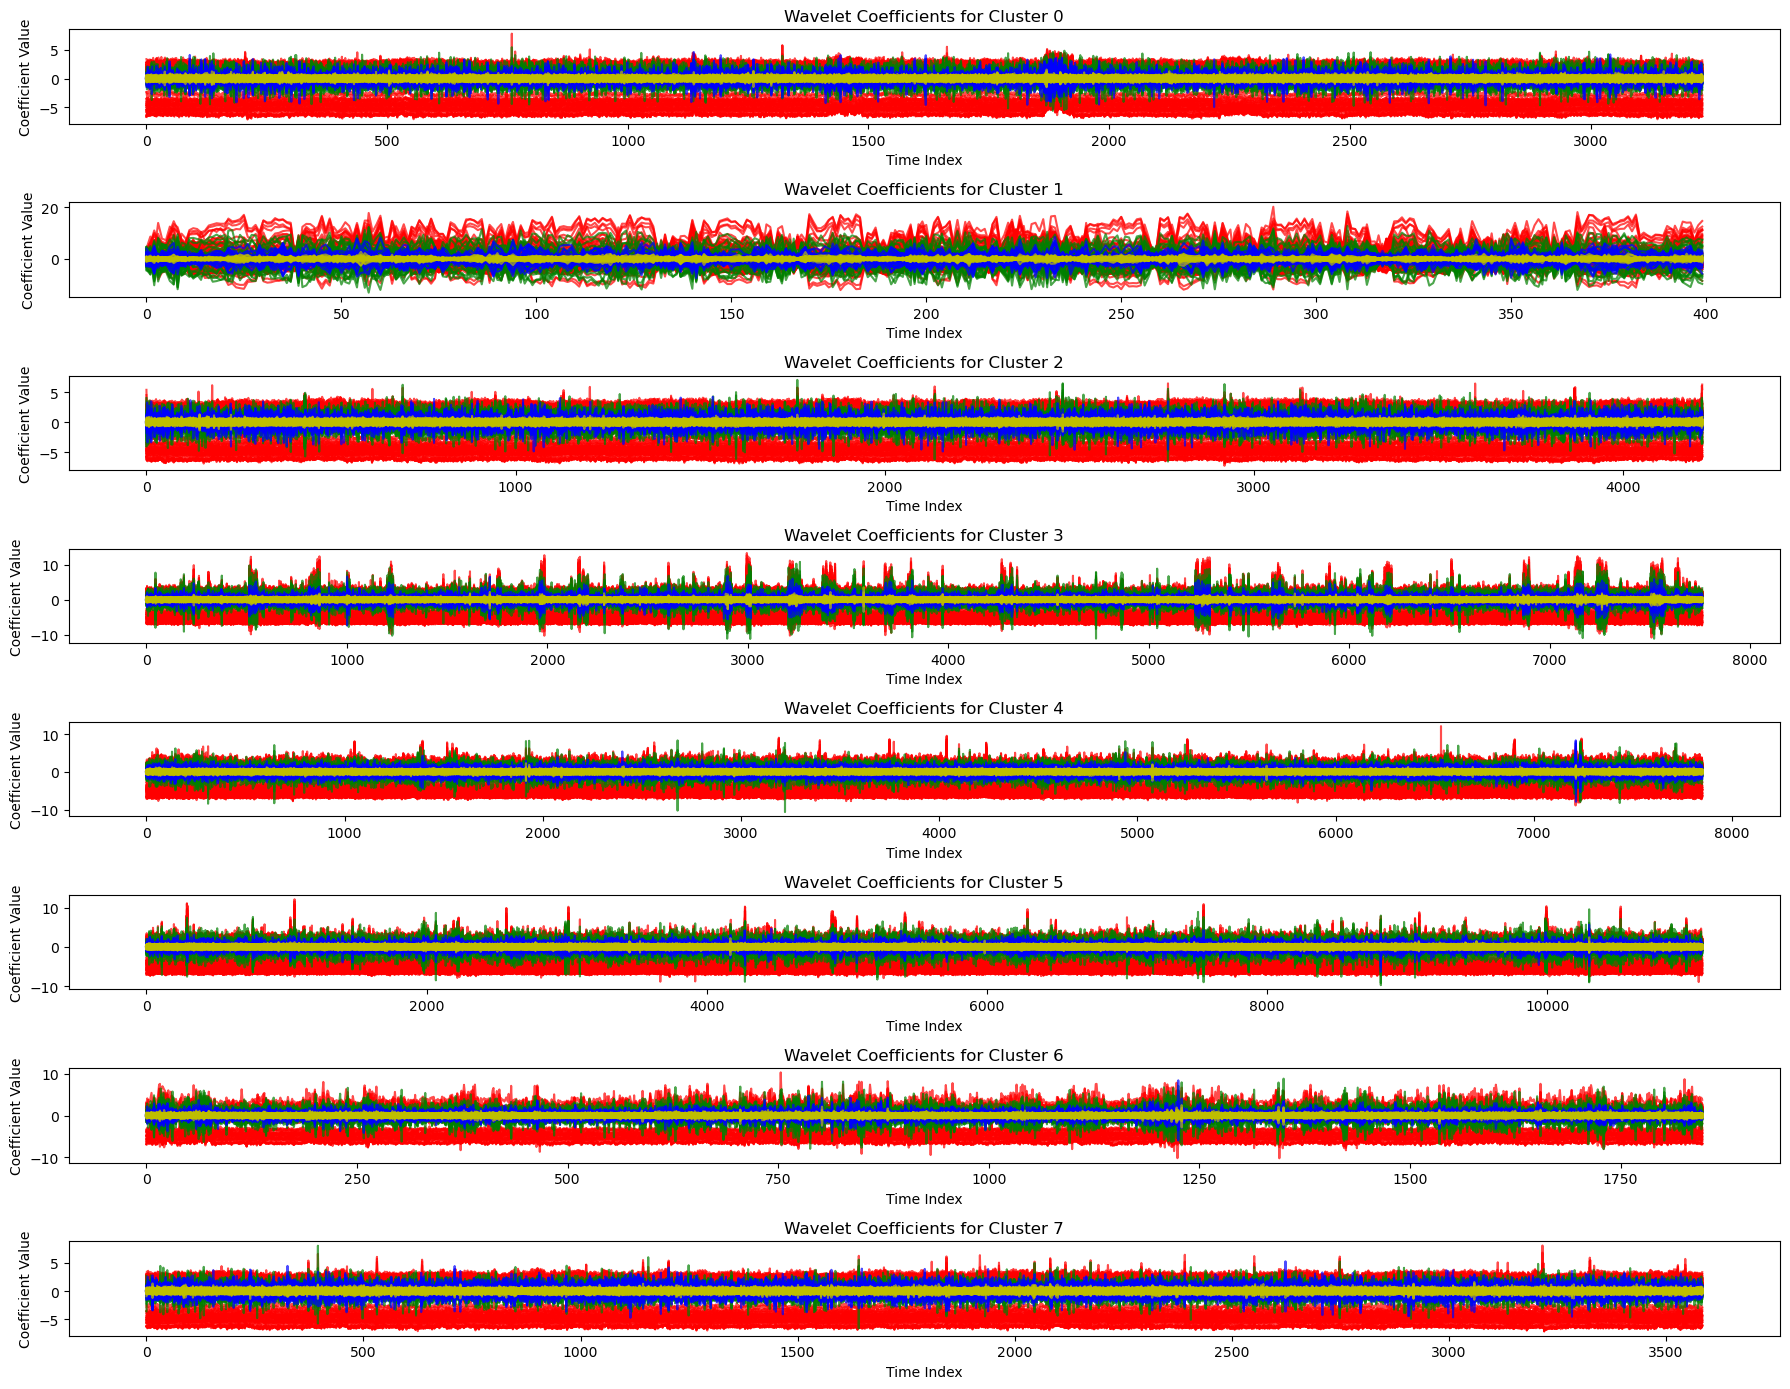

In [18]:
#%% script true
# Define the wavelet function
def wavelet_transform(data):
    coeffs = pywt.wavedec(data[:40000], 'db20', mode='symmetric', level=3)  # Perform wavelet transform using db4 only for small amounts of data
    return coeffs

# Apply wavelet transform on each cluster
wavelet_coeffs = [wavelet_transform(data_normalized[clusters == cluster_id]) for cluster_id in unique_clusters]

# Plot wavelet coefficients for each cluster
fig, axes = plt.subplots(nrows=len(unique_clusters), ncols=1, figsize=(18, 14))


for ax, cluster_id, coeffs in zip(axes.flat, unique_clusters, wavelet_coeffs):
    for i, coeff in enumerate(coeffs):
        ax.plot(coeff, color=colors[i % len(colors)], alpha=0.7)

    ax.set_title(f'Wavelet Coefficients for Cluster {cluster_id}')
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Coefficient Value')

plt.tight_layout()
plt.show()